# Exam vB, PROBLEM 1
Maximum Points = 14

In this problem you will do rejection sampling from complicated distributions, you will also be using your samples to compute certain integrals, a method known as Monte Carlo integration: (Keep in mind that choosing a good sampling distribution is often key to avoid too much rejection)

---

## 1. [4p]
Fill in the remaining part of the function `problem1_rejection` in order to produce samples from the below density using rejection sampling:

$$f[x] = C x^{0.2} (1 - x)^{1.3}$$

for $0 \le x \le 1$, where $C$ is a value such that $f$ above is a density (i.e. integrates to one).

Hint: you do not need to know the value of $C$ to perform rejection sampling.

---

## 2. [2p]
Produce 100000 samples (use fewer if it takes too long) and put the answer in `problem1_samples` from the above distribution and plot the histogram.

---

## 3. [2p]
Define $X$ as a random variable with the density given in part 1. Denote $Y = \sin(10X)$ and use the above 100000 samples to estimate

$$E[Y]$$

and store the result in `problem1_expectation`.

---

## 4. [2p]
Use Hoeffdings inequality to produce a 95% confidence interval of the expectation above and store the result as a tuple in the variable `problem1_interval`.

---

## 5. [4p]
Can you calculate an approximation of the value of $C$ from part 1 using random samples? Provide a plot of the histogram from part 2 together with the true density as a curve, recall that this requires the value of $C$. Explain what method you used and what answer you got.

---

In [46]:
# All the necessary packages that could be necessary:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from scipy import optimize
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    confusion_matrix,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


---

## 1. [4p]
Fill in the remaining part of the function `problem1_rejection` in order to produce samples from the below density using rejection sampling:

$$f[x] = C x^{0.2} (1 - x)^{1.3}$$

for $0 \le x \le 1$, where $C$ is a value such that $f$ above is a density (i.e. integrates to one).

Hint: you do not need to know the value of $C$ to perform rejection sampling.

---

### Rejection sampling for  
$f(x) = C\,x^{0.2}(1-x)^{1.3}, \quad 0 \le x \le 1$

We use the **Accept–Reject sampler**. A convenient choice of proposal distribution is

$$
g(x) = 1, \quad x \in [0,1],
$$

i.e. $X \sim \mathrm{Uniform}(0,1)$.

---

### Step 1: Ignore the normalizing constant $C$

Write the density as

$$
f(x) = C\,\tilde f(x), \qquad \tilde f(x) = x^{0.2}(1-x)^{1.3}.
$$

In rejection sampling, the acceptance probability is

$$
\frac{f(x)}{M g(x)}.
$$

Since $f(x) = C\tilde f(x)$, the constant $C$ cancels out, so we only need an upper bound on $\tilde f(x)$. This is why the value of $C$ is not required.

---

### Step 2: Find the maximum of $\tilde f(x)$

The endpoints give

$$
\tilde f(0) = 0, \qquad \tilde f(1) = 0,
$$

so the maximum occurs inside $(0,1)$.

Maximize $\tilde f(x)$ by maximizing its logarithm:

$$
\ell(x) = \log \tilde f(x) = 0.2\log x + 1.3\log(1-x).
$$

Differentiate and set to zero:

$$
\ell'(x) = \frac{0.2}{x} - \frac{1.3}{1-x} = 0
\;\Rightarrow\;
0.2(1-x) = 1.3x
\;\Rightarrow\;
x^* = \frac{0.2}{0.2 + 1.3} = \frac{2}{15}.
$$

Thus,

$$
M = \max_{x \in [0,1]} \tilde f(x) = (x^*)^{0.2}(1-x^*)^{1.3}.
$$

---

### Step 3: Accept–Reject algorithm

1. Sample $X \sim \mathrm{Uniform}(0,1)$  
2. Sample $U \sim \mathrm{Uniform}(0,1)$  
3. Accept $X$ if
   $$
   U \le \frac{\tilde f(X)}{M}
   $$
   otherwise reject and repeat.

The accepted samples follow the target density
$f(x) = C\,x^{0.2}(1-x)^{1.3}$.

---

### Remarks

- Sampling exactly $x=0$ or $x=1$ is not an issue in practice; $\tilde f(x)=0$ there, so such proposals are always rejected.
- Using $g(x)=1$ is valid, but a proposal distribution closer to the target (e.g. a Beta distribution) would lead to fewer rejections.


### Rejection sampling using a Beta proposal distribution

We want to sample from
$$
f(x) = C\,x^{0.2}(1-x)^{1.3}, \quad 0 \le x \le 1.
$$

Since the shape matches a Beta distribution, we choose a **Beta proposal** to reduce rejection.

---

### Step 1: Choose the proposal distribution

A Beta density has the form
$$
g(x) = \frac{1}{B(\alpha,\beta)} x^{\alpha-1}(1-x)^{\beta-1}.
$$

Matching exponents:
$$
\alpha - 1 = 0.2, \qquad \beta - 1 = 1.3
$$

gives
$$
\alpha = 1.2, \qquad \beta = 2.3.
$$

Thus, we use
$$
g(x) = \mathrm{Beta}(1.2, 2.3).
$$

---

### Step 2: Acceptance probability

Write
$$
f(x) = C\,\tilde f(x), \qquad \tilde f(x) = x^{0.2}(1-x)^{1.3}.
$$

The acceptance probability is
$$
\frac{f(x)}{M g(x)} = \frac{\tilde f(x)}{M g(x)},
$$

since the constant $C$ cancels out.

We choose
$$
M \ge \sup_x \frac{\tilde f(x)}{g(x)}.
$$

This value is estimated numerically.

---

### Step 3: Accept–Reject sampler (code)

```python
import numpy as np
from scipy.stats import beta

def problem1_rejection_beta(n_samples):
    # Unnormalized target density
    def f_tilde(x):
        return x**0.2 * (1 - x)**1.3

    # Proposal distribution Beta(1.2, 2.3)
    alpha = 1.2
    beta_param = 2.3
    proposal = beta(alpha, beta_param)

    # Estimate M numerically
    xs = np.linspace(0.001, 0.999, 10000)
    M = np.max(f_tilde(xs) / proposal.pdf(xs))

    samples = []
    n_trials = 0

    while len(samples) < n_samples:
        x = proposal.rvs()          # sample from Beta proposal
        u = np.random.uniform(0, 1)
        n_trials += 1

        if u <= f_tilde(x) / (M * proposal.pdf(x)):
            samples.append(x)

    samples = np.array(samples)
    acceptance_rate = n_samples / n_trials

    return samples, acceptance_rate


### Why choose a Beta$(1.2, 2.3)$ proposal?

The target density is
$$
f(x) = C\,x^{0.2}(1-x)^{1.3}, \quad 0 \le x \le 1.
$$

A Beta distribution has density
$$
g(x) = \frac{1}{B(\alpha,\beta)} x^{\alpha-1}(1-x)^{\beta-1},
\quad 0 \le x \le 1.
$$

---

### Matching the shape of the target

Ignoring the normalizing constants, the target density is proportional to
$$
x^{0.2}(1-x)^{1.3}.
$$

Comparing powers with the Beta density,
$$
\alpha - 1 = 0.2, \qquad \beta - 1 = 1.3,
$$
which gives
$$
\alpha = 1.2, \qquad \beta = 2.3.
$$

Thus, the proposal
$$
g(x) = \mathrm{Beta}(1.2, 2.3)
$$
has *exactly the same functional form* as the unnormalized target.

---

### Why this is a good proposal

- The proposal and target have the **same support** $[0,1]$
- Their shapes are almost identical
- The ratio $\tilde f(x)/g(x)$ is nearly constant
- The rejection constant $M$ is close to 1
- This leads to a **high acceptance rate**

In contrast, a uniform proposal does not match the shape and results in many unnecessary rejections.

---

### Key takeaway

The parameters $(1.2, 2.3)$ are chosen by **matching the exponents** of the target density to the Beta density. This is a principled way to design an efficient proposal distribution for rejection sampling.


In [47]:
# Part 1
def problem1_rejection(n_samples):
    a = 0.2
    b = 1.3

    # Unnormalized target density
    def f_tilde(x):
        return x**a * (1 - x)**b

    # Maximum of f_tilde
    x_star = a / (a + b)
    M = f_tilde(x_star)
    print(M)

    samples = []
    n_trials = 0

    while len(samples) < n_samples:
        x = np.random.uniform(0, 1)   # proposal g(x) = 1
        u = np.random.uniform(0, 1)
        n_trials += 1

        if u <= f_tilde(x) / M:
            samples.append(x)

    samples = np.array(samples)
    acceptance_rate = n_samples / n_trials

    return samples




# ratio = f(x) / gx
# M_est = ratio.max()
# print("Estimated M: ", M_est)

---

## 2. [2p]
Produce 100000 samples (use fewer if it takes too long) and put the answer in `problem1_samples` from the above distribution and plot the histogram.

0.5548753967283367
Length of samples:  100000


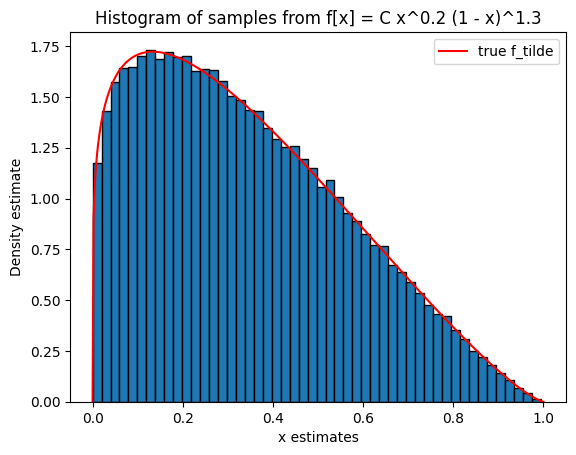

In [48]:
# Part 2
n_samples = 100000
import numpy as np
problem1_samples = problem1_rejection(n_samples)
print("Length of samples: ", len(problem1_samples))

x_values = np.linspace(0,1, 500)
f_tilde = (x_values**0.2 * (1-x_values)**1.3)

f_normalized = f_tilde / np.trapezoid(f_tilde, x_values)

plt.plot(x_values, f_normalized, color='r', label='true f_tilde')

# Plotting:
plt.hist(problem1_samples, bins=50, density=True, edgecolor='black')
plt.title("Histogram of samples from f[x] = C x^0.2 (1 - x)^1.3")
plt.xlabel("x estimates")
plt.ylabel("Density estimate")
plt.legend()
plt.show()


---

## 3. [2p]
Define $X$ as a random variable with the density given in part 1. Denote $Y = \sin(10X)$ and use the above 100000 samples to estimate

$$E[Y]$$

and store the result in `problem1_expectation`.

In [49]:
# Part 3

# The approximation of E[Y] is simply: 
E_Y = (1/n_samples) * sum(np.sin(10*problem1_samples))
problem1_expectation = E_Y

#Approximation of E_Y is:
print("Approzimation of E[Y] is: ", problem1_expectation)

Approzimation of E[Y] is:  0.17792111480536876


---

## 4. [2p]
Use Hoeffdings inequality to produce a 95% confidence interval of the expectation above and store the result as a tuple in the variable `problem1_interval`.

---

In [50]:
# Part 4

# We use these values since we look at the interval of the exectation values from E_Y
a = -1
b = 1

hoef = (b-a) * np.sqrt((np.log(0.05/2)) / (-2*n_samples))
lower = problem1_expectation - hoef
upper = problem1_expectation + hoef

problem1_interval = (lower, upper)
problem1_interval

(np.float64(0.16933172663843402), np.float64(0.1865105029723035))

## 5. [4p]
Can you calculate an approximation of the value of $C$ from part 1 using random samples? Provide a plot of the histogram from part 2 together with the true density as a curve, recall that this requires the value of $C$. Explain what method you used and what answer you got.

---

In [51]:
# Part 5
n_samples = 100000
samples = np.random.uniform(0.0, 1.0, size=n_samples)

I = ((1/n_samples) * np.sum(samples**0.2 * (1-samples)**1.3))

C_hat = 1/I

problem1_C = C_hat
problem1_C

np.float64(3.1025104916358517)

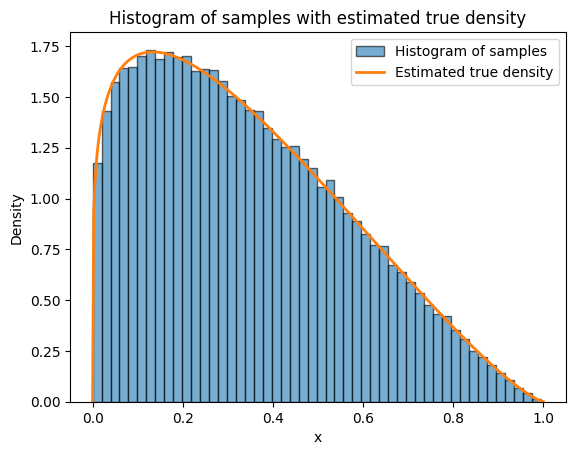

In [52]:
# Part 5
# Write your code to produce the plot here
#XXXXXXX

# 3. Plot the histogram from part 2 together with the estimated true density

# x-grid for plotting the density curve
x_grid = np.linspace(0.0, 1.0, 400)
density_estimate = problem1_C * (x_grid ** 0.2) * ((1.0 - x_grid) ** 1.3)

plt.hist(
    problem1_samples,
    bins=50,
    density=True,
    alpha=0.6,
    edgecolor='black',
    label="Histogram of samples"
)

plt.plot(
    x_grid,
    density_estimate,
    linewidth=2,
    label="Estimated true density"
)

plt.title("Histogram of samples with estimated true density")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

In [53]:
# This cell is just to check that you got the correct formats of your answer
import numpy as np

try:
    assert(isinstance(problem1_rejection(10), np.ndarray))
except:
    print("Try again. You should return a numpy array from problem1_rejection")
else:
    print("Good, your problem1_rejection returns a numpy array")

try:
    assert(isinstance(problem1_samples, np.ndarray))
except:
    print("Try again. your problem1_samples is not a numpy array")
else:
    print("Good, your problem1_samples is a numpy array")

try:
    assert(isinstance(problem1_expectation, float))
except:
    print("Try again. your problem1_expectation is not a float")
else:
    print("Good, your problem1_expectation is a float")

try:
    assert(isinstance(problem1_interval, list) or isinstance(problem1_interval, tuple)) , "problem1_interval not a tuple or list"
    assert(len(problem1_interval) == 2) , "problem1_interval does not have length 2, it should have a lower bound and an upper bound"
except Exception as e:
    print(e)
else:
    print("Good, your problem1_interval is a tuple or list of length 2")

try:
    assert(isinstance(problem1_rejection(10), np.ndarray))
except:
    print("Try again. You should return a numpy array from problem1_rejection_2")
else:
    print("Good, your problem1_rejection_2 returns a numpy array")

0.5548753967283367
Good, your problem1_rejection returns a numpy array
Good, your problem1_samples is a numpy array
Good, your problem1_expectation is a float
Good, your problem1_interval is a tuple or list of length 2
0.5548753967283367
Good, your problem1_rejection_2 returns a numpy array


## Exam vB, PROBLEM 2
**Maximum Points = 13**

Let us build a proportional model ($P(Y = 1 | X) = G(\beta_0 + \beta \cdot X)$ where $G$ is the logistic function)
for the spam vs not spam data. Here we assume that the features are presence vs not presence of a
word, let $X_1, X_2, X_3$ denote the presence (1) or absence (0) of the words (“free”, “prize”, “win”).

---

### 1. [2p]
Load the file `data/spam.csv` and create two numpy arrays, `problem2_X` which has
shape $(n_{\text{emails}}, 3)$ where each feature in `problem2_X` corresponds to
$X_1, X_2, X_3$ from above, `problem2_Y` which has shape $(n_{\text{emails}},)$ and
consists of a 1 if the email is spam and 0 if it is not.

Split this data into a train–calibration–test set where we have the split 40%, 20%, 40%.
Put this data in the designated variables in the code cell.

---

### 2. [4p]
Follow the calculation from the lecture notes where we derive the logistic regression
and implement the final loss function inside the class `ProportionalSpam`.
You can use the Test cell to check that it gives the correct value for a test-point.

---

### 3. [4p]
Train the model `problem2_ps` on the training data.  
The goal is to calibrate the probabilities output from the model.

Start by creating a new variable `problem2_X_pred` (shape $(n_{\text{samples}}, 1)$)
which consists of the predictions of `problem2_ps` on the calibration dataset.

Then train a calibration model using `sklearn.tree.DecisionTreeRegressor`,
store this trained model in `problem2_calibrator`.

---

### 4. [3p]
Use the trained model `problem2_ps` and the calibrator `problem2_calibrator` to make
final predictions on the testing data, store the prediction in
`problem2_final_predictions`.

Compute the $0 - 1$ test-loss and store it in `problem2_01_loss` and provide a
99% confidence interval of it.  
Store this interval in the variable `problem2_interval`
(this should again be a tuple as in Problem 1).


### 1. [2p]
Load the file `data/spam.csv` and create two numpy arrays, `problem2_X` which has
shape $(n_{\text{emails}}, 3)$ where each feature in `problem2_X` corresponds to
$X_1, X_2, X_3$ from above, `problem2_Y` which has shape $(n_{\text{emails}},)$ and
consists of a 1 if the email is spam and 0 if it is not.

Split this data into a train–calibration–test set where we have the split 40%, 20%, 40%.
Put this data in the designated variables in the code cell.


In [54]:
data = pd.read_csv("../../../data/spam.csv", encoding="latin-1", usecols=[0,1])

texts = data["v2"].astype(str)
#print(texts)
#print(data.head(5))

words = ["free", "prize", "win"]



# Part 1
problem2_X = np.column_stack([texts.str.contains(w, case=False, regex=False).astype(int) for w in words])
print(problem2_X)

problem2_Y = (data["v1"] == "spam").astype(int).values 

n = problem2_X.shape[0]
print(n)

n_train = int(n * 0.4)
n_calib = int(n * 0.2)

problem2_X_train = problem2_X[:n_train]
problem2_X_calib = problem2_X[n_train:n_train+n_calib]
problem2_X_test = problem2_X[n_train+n_calib:]

problem2_Y_train = problem2_Y[:n_train]
problem2_Y_calib = problem2_Y[n_train:n_train+n_calib]
problem2_Y_test = problem2_Y[n_train+n_calib:]

print(problem2_X_train.shape,
      problem2_X_calib.shape,
      problem2_X_test.shape,
      problem2_Y_train.shape,
      problem2_Y_calib.shape,
      problem2_Y_test.shape)


[[0 0 0]
 [0 0 0]
 [1 0 1]
 ...
 [0 0 0]
 [1 0 0]
 [0 0 0]]
5572
(2228, 3) (1114, 3) (2230, 3) (2228,) (1114,) (2230,)


In [55]:
# Part 1

data = pd.read_csv("../../../data/spam.csv", encoding="latin-1", usecols=[0,1])
#print(data.head(5))

words = ["free", "prize", "win"]

texts = data["v2"]
#print("Texts", texts)

problem2_X = np.column_stack([texts.str.contains(w, case=False, regex=False).astype(int) for w in words])
#print(problem2_X)

problem2_Y = (data["v1"] == "spam").astype(int).values
#print(problem2_Y)

n = problem2_X.shape[0]
#print(n)
n_train = int(n * 0.4)
n_calib = int(n * 0.2)


# Training points from 0 to n_train -1
problem2_X_train = problem2_X[:n_train]
# Start from n_train to n_train + n_calib -1
problem2_X_calib = problem2_X[n_train:n_train + n_calib]
# From n_train + n_calib to end
problem2_X_test  = problem2_X[n_train + n_calib:]

problem2_Y_train = problem2_Y[:n_train]
problem2_Y_calib = problem2_Y[n_train:n_train + n_calib]
problem2_Y_test = problem2_Y[n_train + n_calib:]

print(problem2_X_train.shape,
      problem2_X_calib.shape,
      problem2_X_test.shape,
      problem2_Y_train.shape,
      problem2_Y_calib.shape,
      problem2_Y_test.shape)


# This problem could also be solved using this code below, but this was not used since there
# was already variable names written below

# Split 40% train, 60% temp
# problem2_X_train, X_temp, problem2_Y_train, y_temp = train_test_split(
#     problem2_X, problem2_Y,
#     test_size=0.60,
#     random_state=42,
#     stratify=problem2_Y
# )

# # Split temp (60%) into 20% calib and 40% test
# # calib should be 1/3 of temp since 0.20 / 0.60 = 1/3
# problem2_X_calib, problem2_X_test, problem2_Y_calib, problem2_Y_test = train_test_split(
#     X_temp, y_temp,
#     test_size=2/3,          # leaves 1/3 for calib
#     random_state=42,
#     stratify=y_temp
# )


(2228, 3) (1114, 3) (2230, 3) (2228,) (1114,) (2230,)


---

### 2. [4p]
Follow the calculation from the lecture notes where we derive the logistic regression
and implement the final loss function inside the class `ProportionalSpam`.
You can use the Test cell to check that it gives the correct value for a test-point.

---

In [56]:
# Part 2
class ProportionalSpam(object):
    def __init__(self):
        self.coeffs = None
        self.result = None

    # define the objective/cost/loss function we want to minimise
    def loss(self, X, Y, coeffs):
        z = coeffs[0] + X @ coeffs[1:]
        t = 2*Y - 1
        return np.mean(np.log(1+np.exp(-t * z)))

    def fit(self, X, Y):
        import numpy as np
        from scipy import optimize
        # Use the f above together with an optimization method from scipy
        # to find the coefficients of the model
        opt_loss = lambda coeffs: self.loss(X, Y, coeffs)
        initial_arguments = np.zeros(shape=X.shape[1] + 1)
        self.result = optimize.minimize(opt_loss,
                                        initial_arguments,
                                        method='cg')
        self.coeffs = self.result.x

    def predict(self, X):
        # Use the trained model to predict Y
        if (self.coeffs is not None):
            G = lambda x: np.exp(x) / (1 + np.exp(x))
            return np.round(
                10 * G(np.dot(X, self.coeffs[1:]) + self.coeffs[0])
            ) / 10  # This rounding is to help you with the calibration


### 3. [4p]
Train the model `problem2_ps` on the training data.  
The goal is to calibrate the probabilities output from the model.

Start by creating a new variable `problem2_X_pred` (shape $(n_{\text{samples}}, 1)$)
which consists of the predictions of `problem2_ps` on the calibration dataset.

Then train a calibration model using `sklearn.tree.DecisionTreeRegressor`,
store this trained model in `problem2_calibrator`.

---

In [57]:
# Part 3
from sklearn.tree import DecisionTreeRegressor

problem2_ps = ProportionalSpam()
problem2_ps.fit(problem2_X_train, problem2_Y_train)

problem2_X_pred = problem2_ps.predict(problem2_X_calib).reshape(-1, 1)


problem2_calibrator = DecisionTreeRegressor()

# Calibrator training input = base model predictions (on calibration set)
# Calibrator target = true labels (on calibration set)
problem2_calibrator.fit(problem2_X_pred, problem2_Y_calib)


,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


---

### 4. [3p]
Use the trained model `problem2_ps` and the calibrator `problem2_calibrator` to make
final predictions on the testing data, store the prediction in
`problem2_final_predictions`.

Compute the $0 - 1$ test-loss and store it in `problem2_01_loss` and provide a
99% confidence interval of it.  
Store this interval in the variable `problem2_interval`
(this should again be a tuple as in Problem 1).

In [58]:
# Part 4

# These are the predicted probabilities
problem2_final_predictions = problem2_calibrator.predict(problem2_ps.predict(problem2_X_test).reshape(-1,1))

print("This is the average final predictions: ", problem2_final_predictions.mean())

# In order to compute this loss we first need to convert the predicted probabilities to a decision
# recall the Bayes classifier?

# These are the predictions from the model above 0.5
problem2_hard_predictions = (problem2_final_predictions >= 0.5).astype(int)
#print(len(problem2_hard_predictions))

# missclassification rate
errors = (problem2_hard_predictions != problem2_Y_test).astype(int)

problem2_01_loss = np.mean(errors)
print("The loss is: ", problem2_01_loss)

# Use Hoeffding's inequality to compute a 99% confidence interval for the true 0-1 loss
n_test = len(problem2_Y_test)
a = 0.0    
b = 1.0
alpha = 0.01 # 99% confidence -> alpha = 0.01
n = len(problem2_Y_test)

eps = (b-a) * np.sqrt(np.log(alpha/2) / (-2*n))

lower = max(0.0, problem2_01_loss - eps)
upper = min(1.0, problem2_01_loss + eps)

# Recall the interval is given as a tuple (a,b) or a list [a,b]
problem2_interval = (lower, upper)
print("The interval of the 99% confidence interval: ", problem2_interval)


This is the average final predictions:  0.12746260079533306
The loss is:  0.1031390134529148
The interval of the 99% confidence interval:  (np.float64(0.06867216655476562), np.float64(0.13760586035106398))


Local Test for Exam vB, PROBLEM 2 Evaluate cell below to make sure your answer is valid.
You should not modify anything in the cell below when evaluating it to do a local test of your
solution. You may need to include and evaluate code snippets from lecture notebooks in cells above
to make the local test work correctly sometimes (see error messages for clues). This is meant to
help you become efficient at recalling materials covered in lectures that relate to this problem. Such
local tests will generally not be available in the exam

In [59]:
try:
    import numpy as np
    test_instance = ProportionalSpam()
    test_loss = test_instance.loss(
        np.array([[1,0,1],[0,1,1]]),
        np.array([1,0]),
        np.array([1.2,0.4,0.3,0.9])
    )
    assert (np.abs(test_loss - 1.2828629432232497) < 1e-6)
    print("Your loss was correct for a test point")
except:
    print("Your loss was not correct on a test point")

Your loss was correct for a test point


## Exam vB, PROBLEM 3
**Maximum Points = 13**

Consider the following four Markov chains, answer each question for all chains:
![Markov chain diagrams](exam240607-markovImages.png)

### 1. [2p]
What is the transition matrix?

### 2. [2p]
Is the Markov chain irreducible?

### 3. [3p]
Is the Markov chain aperiodic?  
What is the period for each state?

Hint: Recall our definition of period:  
Let $$T := \{ t \in \mathbb{N} : P^t(x, x) > 0 \}$$  
and the greatest common divisor of $T$ is the period.

### 4. [3p]
Does the Markov chain have a stationary distribution, and if so, what is it?

### 5. [3p]
Is the Markov chain reversible?


Consider the following four Markov chains, answer each question for all chains:
![Markov chain diagrams](exam240607-markovImages.png)

### 1. [2p]
What is the transition matrix?

In [60]:
# PART 1
#------------------------TRANSITION MATRIX -------------------------------
# Answer each one by supplying the transition matrix as a numpy array
# of shape (n_states,n_states), where state (A,B,...) corresponds to index (0,1,...)
problem3_A = np.array([[0.8, 0.2, 0.0, 0.0], [0.6, 0.2, 0.2, 0.0], [0.0, 0.4, 0.0, 0.6], [0.0, 0.0, 0.8, 0.2]])
problem3_B = np.array([[0.0, 0.2, 0.0, 0.8], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.5, 0.0, 0.5, 0.0]])
problem3_C = np.array([[0.2, 0.3, 0.0, 0.0, 0.5], [0.2, 0.2, 0.6, 0.0, 0.0], [0.0, 0.4, 0.0, 0.6, 0.0], [0.0, 0.0, 0.0, 0.6, 0.4], [0.0, 0.0, 0.0, 0.4, 0.6]])
problem3_D = np.array([[0.8, 0.2, 0.0, 0.0], [0.6, 0.2, 0.2, 0.0], [0.0, 0.4, 0.0, 0.6], [0.1, 0.0, 0.7, 0.2]])


-----
Is the Markov chain irreducible?

In [61]:
# PART 2
#------------------------REDUCIBLE -------------------------------
# Answer each one with a True or False
problem3_A_irreducible = True
problem3_B_irreducible = False
problem3_C_irreducible = False
problem3_D_irreducible = True


In [62]:
# PART 3
#------------------------APERIODIC-------------------------------
# Answer each one with a True or False
problem3_A_is_aperiodic = True
problem3_B_is_aperiodic = False
problem3_C_is_aperiodic = True
problem3_D_is_aperiodic = True

# Answer the following with the period of the states as a numpy array
# of shape (n_states,)
problem3_A_periods = np.array([1,1,1,1])
problem3_B_periods = np.array([2,2,2,2])
problem3_C_periods = np.array([1,1,1,1,1])
problem3_D_periods = np.array([1,1,1,1])


-----
### 4. [3p]
Does the Markov chain have a stationary distribution, and if so, what is it?

-----



In [63]:
# This is a valid function to always find the stationary distribution:


import numpy as np

import numpy as np

def stationary_distribution(P, tol=1e-12, verify=True):
    """
    Compute the stationary distribution of a finite-state Markov chain.

    Parameters
    ----------
    P : np.ndarray, shape (n, n)
        Transition matrix. Rows should sum to 1 (row-stochastic).
    tol : float, optional
        Tolerance used for cleaning small numerical noise.
    verify : bool, optional
        If True, checks that the result is approximately stationary.

    Returns
    -------
    pi : np.ndarray, shape (n,)
        Stationary distribution vector (non-negative, sums to 1).

    Notes
    -----
    This solves the linear system:

        (P^T - I) * pi = 0,  with  sum(pi) = 1

    by replacing one of the equations with the normalization condition.
    It assumes that a (unique) stationary distribution exists.
    """
    P = np.asarray(P, dtype=float)
    n = P.shape[0]

    if P.shape[0] != P.shape[1]:
        raise ValueError("P must be a square matrix.")

    # Build A * pi = b
    A = P.T - np.eye(n)
    b = np.zeros(n)

    # Replace last row with normalization condition: sum_i pi_i = 1
    A[-1, :] = 1.0
    b[-1] = 1.0

    # Solve linear system
    pi = np.linalg.solve(A, b)

    # Clean tiny numerical noise
    pi[np.abs(pi) < tol] = 0.0

    # If there are small negative values, clamp them to 0 and renormalize
    if np.any(pi < -tol):
        # Serious negativity -> indicate potential problem
        raise RuntimeError(
            "Computed stationary distribution has significantly negative entries. "
            "Check that P is a valid transition matrix with a unique stationary distribution."
        )

    # Clamp small negatives and renormalize
    pi = np.maximum(pi, 0.0)
    s = pi.sum()
    if not np.isfinite(s) or s <= 0:
        raise RuntimeError("Failed to compute a valid stationary distribution (sum <= 0).")
    pi /= s

    if verify:
        # Check stationarity: pi P ≈ pi
        if not np.allclose(pi @ P, pi, atol=1e-8):
            raise RuntimeError("Result does not satisfy pi P ≈ pi. Check the input matrix P.")

    return pi









PA = problem3_A
PB = problem3_B
PC = problem3_C
PD = problem3_D

print("This is stationary distribution: ", stationary_distribution(PA))
print("This is stationary distribution: ", stationary_distribution(PB))
print("This is stationary distribution: ", stationary_distribution(PC))
print("This is stationary distribution: ", stationary_distribution(PD))



This is stationary distribution:  [0.61538462 0.20512821 0.1025641  0.07692308]
This is stationary distribution:  [0.  0.5 0.5 0. ]
This is stationary distribution:  [0.  0.  0.  0.5 0.5]
This is stationary distribution:  [0.64516129 0.20430108 0.08602151 0.06451613]


In [64]:
# PART 4
#------------------------STATIONARY DISTRIBUTION-----------------
# Answer each one with a True or False

# A Markov chain does not have a stationary distribution only if it is not a valid finite Markov chain, i.e. 
# the transition matrix is not square, has negative entries, or its rows do not sum to 1.
# Every finite, valid transition matrix has at least one stationary distribution.
problem3_A_has_stationary = True
problem3_B_has_stationary = True
problem3_C_has_stationary = True
problem3_D_has_stationary = True

# Answer the following with the stationary distribution as a numpy array of shape (n_states,)
# if the Markov chain has a stationary distribution otherwise answer with False
problem3_A_stationary_dist = stationary_distribution(PA)
problem3_B_stationary_dist = stationary_distribution(PB)
problem3_C_stationary_dist = stationary_distribution(PC)
problem3_D_stationary_dist = stationary_distribution(PD)

print("Stationary distribution for A: ", problem3_A_stationary_dist) # kör .sum och kolla så att det blir 1 också.
print("Stationary distribution for B: ", problem3_B_stationary_dist)
print("Stationary distribution for C: ", problem3_C_stationary_dist)
print("Stationary distribution for D: ", problem3_D_stationary_dist)

Stationary distribution for A:  [0.61538462 0.20512821 0.1025641  0.07692308]
Stationary distribution for B:  [0.  0.5 0.5 0. ]
Stationary distribution for C:  [0.  0.  0.  0.5 0.5]
Stationary distribution for D:  [0.64516129 0.20430108 0.08602151 0.06451613]


In [65]:
# PART 5
#------------------------REVERSIBLE-----------------
# Answer each one with a True or False

# This is a function that checks the reversibility of any markov chain:
import numpy as np

# P = matrix
# pi = linear equation system we have 

#The stationary distributions of each matrix:
problem3_A_stationary_dist = stationary_distribution(PA)
problem3_B_stationary_dist = stationary_distribution(PB)
problem3_C_stationary_dist = stationary_distribution(PC)
problem3_D_stationary_dist = stationary_distribution(PD)

# The Markov matrixes:
problem3_A = np.array([[0.8, 0.2, 0.0, 0.0], [0.6, 0.2, 0.2, 0.0], [0.0, 0.4, 0.0, 0.6], [0.0, 0.0, 0.8, 0.2]])
problem3_B = np.array([[0.0, 0.2, 0.0, 0.8], [0.0, 0.0, 1.0, 0.0], [0.0, 1.0, 0.0, 0.0], [0.5, 0.0, 0.5, 0.0]])
problem3_C = np.array([[0.2, 0.3, 0.0, 0.0, 0.5], [0.2, 0.2, 0.6, 0.0, 0.0], [0.0, 0.4, 0.0, 0.6, 0.0], [0.0, 0.0, 0.0, 0.6, 0.4], [0.0, 0.0, 0.0, 0.4, 0.6]])
problem3_D = np.array([[0.8, 0.2, 0.0, 0.0], [0.6, 0.2, 0.2, 0.0], [0.0, 0.4, 0.0, 0.6], [0.1, 0.0, 0.7, 0.2]])


# Code for checking reversibility for ANY matrix!:

def is_reversible(P, stationary_dist, tol=1e-12):
    n = P.shape[0]
    for i in range(n):
        for j in range(n):
            left = stationary_dist[i] * P[i,j]
            right = stationary_dist[j] * P[j,i]
            if not np.isclose(left, right, atol=tol):
                return False
    return True


# print("Is Matrix A Reversible:", is_reversible(problem3_A, problem3_A_stationary_dist))
# print("Is Matrix B Reversible:", is_reversible(problem3_B, problem3_B_stationary_dist))
# print("Is Matrix C Reversible:", is_reversible(problem3_C, problem3_C_stationary_dist))
# print("Is Matrix D Reversible:", is_reversible(problem3_D, problem3_D_stationary_dist))




problem3_A_is_reversible = is_reversible(problem3_A, problem3_A_stationary_dist)
problem3_B_is_reversible = is_reversible(problem3_B, problem3_B_stationary_dist)
problem3_C_is_reversible = is_reversible(problem3_C, problem3_C_stationary_dist)
problem3_D_is_reversible = is_reversible(problem3_D, problem3_D_stationary_dist)

print("Is Matrix A Reversible: ", problem3_A_is_reversible)
print("Is Matrix B Reversible: ", problem3_B_is_reversible)
print("Is Matrix C Reversible: ", problem3_C_is_reversible)
print("Is Matrix D Reversible: ", problem3_D_is_reversible)


Is Matrix A Reversible:  True
Is Matrix B Reversible:  True
Is Matrix C Reversible:  True
Is Matrix D Reversible:  False
